In [16]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [52]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


**Завдання 1**: Завантажте дані `medical-charges.csv` в пандас датафрейм і виведіть перші 5 записів. Напишіть, як ви можете підійти до вирішення задачі прогнозування колонки `charges` на основі інших колонок виходячи з наявних на даний момент знань (без ML методів, чисто з використанням аналітики). Запишіть 3 або більше ідей, які приходять вам на думку нижче:

In [18]:
medical_df = pd.read_csv('../assets/hw_2_1/medical-charges.csv')

In [19]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Ideas for predicting charges:

1. Calculate average charges for each category in categorical variables (such as sex, smoker, region, etc.). For continuous variables like BMI and age, create bins to group values. Then, estimate charges by averaging the means of the corresponding groups for each record.

2. Represent charges as a function of multiple unknown coefficients for each feature, and iteratively adjust these coefficients to minimize the error (a simplified form of regression without machine learning libraries).

3. Use statistical correlation analysis to identify the features that have the strongest relationship with charges. Based on the most correlated feature, divide the data into groups and calculate the mean charges for each group. This allows to approximate charges by assigning the average group value to new records.

4. Apply rule-based logic with simple surcharges and bonuses based on domain knowledge: for example, increase charges for smokers, overweight individuals, older age groups, or higher number of children. Such rules can be derived from common sense or expert advice.

5. Build a simple table of surcharges and bonuses, where each factor contributes additively to the final charge. In real-life scenarios, consulting domain experts (such as insurance actuaries or healthcare professionals) may be necessary to define proper weights and rules for each risk factor.


**Завдання 2**: Візуалізуйте розподіл медичних зборів (`charges`) у вигляді інтерактивної гістограми plotly з розбиттями за категоріями ознак
1. `sex`
2. `region`

Додайте маржинальний графік у вигляді бокс-плота вгорі по дикретним категоріям ознак.
Скористайтесь прикладом візуалізації з лекції.
Опишіть свої спостереження.

In [20]:
def plot_histogram(df, group_col, feature_col, nbins=50):
    fig = px.histogram(
        df,
        x=feature_col,
        color=group_col,
        nbins=nbins,
        marginal='box',
        title=f'Distribution of {feature_col.capitalize()} by {group_col.capitalize()}'
    )
    fig.update_layout(
        xaxis_title='Charges',
        yaxis_title='Count',
        bargap=0.1
    )
    fig.show()

In [21]:
plot_histogram(medical_df, 'sex', 'charges')

In [22]:
plot_histogram(medical_df, 'region', 'charges')

### Summary

1. The distribution of medical charges (`charges`) is highly right-skewed, with most individuals having relatively low charges and a small number of individuals with extremely high charges.

2. When splitting by sex, both male and female groups exhibit similar overall distributions. There is a slightly higher concentration of high-charge cases among males, but the difference is not substantial. The median and interquartile ranges are quite close for both groups.

3. When splitting by region, all regions demonstrate similar distribution shapes. Some regions (such as southeast and southwest) have slightly more cases with higher charges, but overall, region does not appear to be a strong predictor of charges.

4. The presence of extreme outliers across all groups suggests that factors such as smoking status, BMI, and age may have a more significant impact on charges compared to sex or region.


**Завдання 3**: Візуалізуйте з `plotly` розподіл кожного з настуних стовпців відносно того, чи є людина курцем (`smoker`)
- `region`
- `children`

та опишіть коротко свої спостереження.

In [23]:
def get_smoker_bins(df):
    return len(df['smoker'].unique()) if df['smoker'].dtype != 'object' else None

In [24]:
plot_histogram(medical_df, 'smoker', 'region', get_smoker_bins(medical_df))

In [25]:
plot_histogram(medical_df, 'smoker', 'children', get_smoker_bins(medical_df))

### Summary

1. When analyzing the distribution of `region` by `smoker` status, the proportion of smokers appears fairly consistent across regions. All regions have a significantly larger proportion of non-smokers, while the number of smokers is smaller but present in each region. There is no clear evidence that smoking status is strongly related to region.

2. When analyzing the distribution of `children` by `smoker` status, most individuals have no children. Both smokers and non-smokers demonstrate similar distributions across the number of children. There is no visible tendency for smokers to have significantly more or fewer children compared to non-smokers.

3. Overall, based on these two features, neither `region` nor `children` appear to be strong predictors of smoking status. Further analysis may be required for features such as BMI, age, and charges to better understand the differences between smokers and non-smokers.


**Завдання 4**: Візуалізуйте звʼязок між стовпцем `charges` та `children` використовуючи графіки-скрипки (`px.violin`). Опишіть свої спостереження.

In [26]:
fig = px.violin(
    medical_df,
    x='children',
    y='charges',
    box=True,
    points='all',
    title='Distribution of Charges by Number of Children'
)

fig.update_layout(
    xaxis_title='Number of Children',
    yaxis_title='Charges'
)

fig.show()

### Summary

The violin plot shows that the number of children has no strong impact on medical charges. Most individuals, regardless of how many children they have, are concentrated within the same lower charge range. High-charge outliers appear across all groups but are most frequent in individuals without children. This suggests that other factors, such as smoking status, BMI, or age, are likely more influential in determining medical charges.


**Завдання 5.** Розглянемо модель для користувачів, які не є курцями (`no_smoker_df`):

$$charges = w \times age + b$$

Спробуйте 3 різні пари параметрів `w` та `b` аби вручну підігнати лінію під дані використовуючи наведені допоміжні функції `estimate_charges` та `try_parameters`. Опишіть спостереження.
Пари параметрів мають бути НЕ такі, як були наведені в лекції.

In [27]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [28]:
def estimate_charges(age, w, b):
    return w * age + b

In [29]:
def try_parameters(df, w, b):
    ages = df.age
    target = df.charges

    estimated_charges = estimate_charges(ages, w, b)

    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

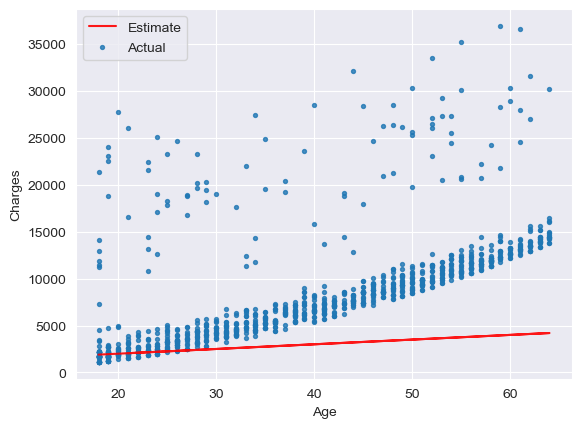

In [30]:
try_parameters(non_smoker_df, w=50, b=1000)
plt.show()

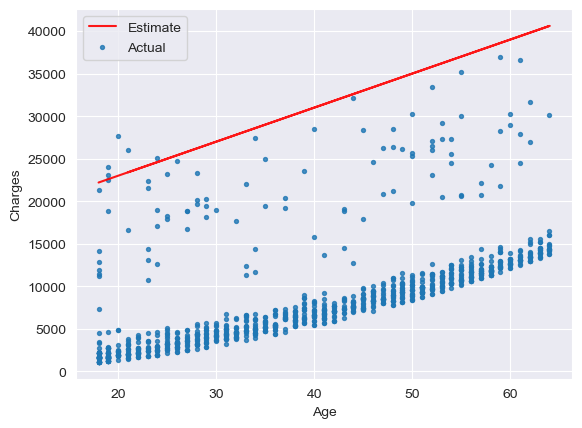

In [31]:
try_parameters(non_smoker_df, w=400, b=15000)
plt.show()

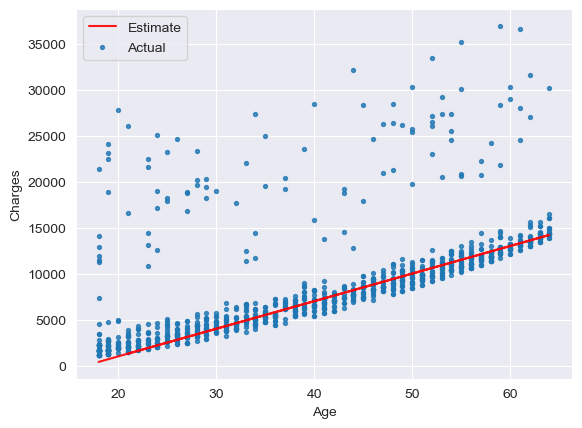

In [51]:
try_parameters(non_smoker_df, w=300, b=-5000)
plt.show()

### Summary

I experimented with different parameter values for the linear model:

- Initial trials with low and high parameter values showed clear underestimation and overestimation of charges, respectively.
- After adjusting the slope to `w=300` and intercept to `b=-5000`, the fitted line aligned more closely with the actual data, especially for younger and middle-aged non-smokers.
- While this simple linear model captures the general positive trend between age and charges, it still struggles to fit higher charges observed for older individuals. This indicates that other factors not included in the model contribute significantly to charge variations.




**Завдання 6**: Напишіть фукнцію для обчислення root mean squared error згідно з формулою цієї метрики точності моделі з використанням `numpy`.

Обчисліть RMSE для тих пар пареметрів, які Ви спробували в завданні 5.

Яке найнижче значення втрат ви зможете досягти? Чи можете ви придумати загальну стратегію для знаходження кращих значень $w$ та $b$ методом проб та помилок?

In [53]:
def calculate_rmse(df, w, b):
    ages = df.age
    target = df.charges
    predictions = estimate_charges(ages, w, b)
    rmse = np.sqrt(np.mean((target - predictions)**2))
    return rmse

In [54]:
w_range = np.arange(200, 400, 20)
b_range = np.arange(-10000, 10000, 2000)

best_rmse = float('inf')
best_w = None
best_b = None

for w in w_range:
    for b in b_range:
        rmse = calculate_rmse(non_smoker_df, w, b)
        if rmse < best_rmse:
            best_rmse = rmse
            best_w = w
            best_b = b

print(f"Best parameters: w={best_w}, b={best_b}, RMSE={best_rmse}")

Best parameters: w=260, b=-2000, RMSE=4667.658904656397


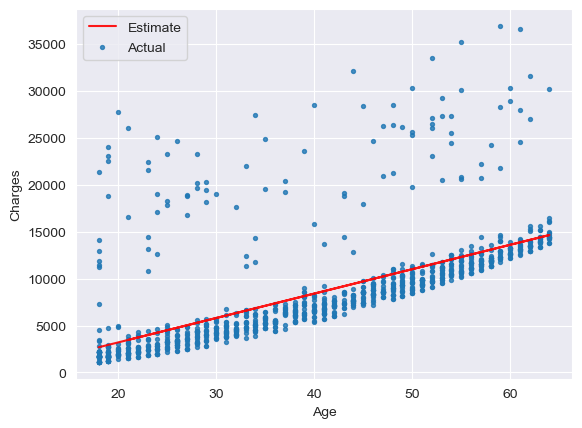

In [55]:
try_parameters(non_smoker_df, best_w, best_b)
plt.show()

### Summary

Using the manually written RMSE function, I performed a grid search over a narrower and more reasonable range of `w` and `b` values. The best result was obtained at:

- w = [260]
- b = [-2000]
- RMSE = [4667.66]

This approach demonstrates that manually testing different parameter combinations can help approximate optimal values. A practical strategy is to start with a wide range, observe the results, and then iteratively focus on narrower ranges based on observed trends.